## Experiment 2 - Advanced RAG System

Wie auch in *Experiment 1* vergleichen wir hier erneut eine komplette RAG-Pipeline, diesmal aber mit einigen **komplexeren retrieval-Schritten**. Der Ablauf ist analog `03_run_naive_rag` Skript.<br>
<br>
• Schritt 1: **Advanced RAG pipeline aufsetzen**: Erneut erstellen wir eine RAG pipeline, diesmal mit erweiterten Funktionen.<br>
<br>
• Schritt 2: **Antworten generieren**: Fragen werden durch das System geschickt.<br>
<br>
• Schritt 3: **Performance messen**: Die generierten Antworten mit den 3 Metriken der *RAG Triade* bewertet.<br>
<br>

In [18]:
# Imports & keys 

import os
os.chdir("/workspace")

from pathlib import Path
import json
import sys, subprocess, json, asyncio, nest_asyncio
nest_asyncio.apply()

import src.graph.advanced_rag as advanced_rag_graph
from src.graph.components.configuration import Configuration

from langchain_core.runnables import RunnableConfig

### Was macht die Pipeline?

Im Unterschied zur *naiven* Pipeline aus Experiment 1 durchläuft eine Frage jetzt mehrere Stufen:

1. **Query Decomposition**  
   - Ein separates LLM bestimmt zunächst, ob die input Frage komplex (bzw. mehrteilig ist). 
   - Falls dies zutrifft, wird die Frage durch ein weiteres LLM in *Sub-Queries* zerlegt.

2. **Mehrstufiges Retrieval**  
   - Für die Original-Frage **und** jede weitere Sub-Query wird der Vectorstore abgefragt.  
   - Die Teilergebnisse werden mit **RRF (Reciprocal Rank Fusion)** zusammengeführt:  
     Dokumente, die in mehreren Lister häufiger bzw. weit oben erscheinen, kommen nach oben,  
     während Dokumente, die nur selten oder weit hinten auftauchen, nach unten rutschen.  

3. **Cross-Encoder Reranking (Cohere API nötig)**  
   - Die Top-N Passagen werden noch einmal mit einem Cross-Encoder sortiert,  
     um semantisch *feinere* Relevanzbewertungen zu berechnen.  

4. **Answer Generation**  
   - Frage + neu gerankte Kontexte landen im LLM, das die finale Antwort schreibt.  


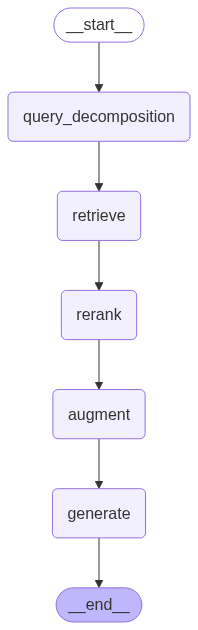

In [19]:
advanced_rag_graph.graph

In [20]:
# graph configuration 
cfg = Configuration(
    provider="anthropic", # choose the provider 
    answer_gen_model="claude-3-5-haiku-20241022", # choose the LLM gen model
    top_k=10, # number of top document chunks to retrieve
    temperature=0.5, # set the temperature
    num_answers=3, # number of answers to generate 
    max_tokens=2048, # maximum tokens for the answer generation (keep it short for this test)
)

run_cfg = RunnableConfig(
    configurable=cfg.model_dump()
    )

In [21]:
# run a test question
query = "welche neuen medikamente zur behandlung von psychosen gibt es und wie wirken diese?"

result = advanced_rag_graph.graph.invoke(
    {"question": query}, 
    config = run_cfg)

#result

In [22]:
# question
print(f"Frage: \n{result['question']}")
print("-----"*10)
# query decomposition?
print("\nQuery decomposition nötig?", result["needs_decomposition"])
print("-----"*10)
# generated sub queries
print("\nGenerated sub query: ")
[print(f"Sub Query no {idx}:", query) for idx, query in enumerate(result["sub_queries"])]
print("-----"*10)
# item count in retrieval lists
print("\nNumber of retrieval lists:", len(result["docs_by_query"]))
print("-----"*10)
# item count after reranking
print("\nNumber of retrieved documents after reranking:", len(result["context"]))
print("-----"*10)
# context
for i, doc in enumerate(result["context"][:3], start=1):
    print(f"\nContext No. {i}:")
    print(f"Title: {doc.metadata.get('title')}")
    print(f"Doc ID: {doc.id}")
    print(f"Text:\n{doc.page_content[:400]}...")  
print("-----"*10)
# answer
for i, doc in enumerate(result["answers"], start=1):
    print(f"\nAnswer No. {i}")
    print(f"Answer: {doc}")


Frage: 
welche neuen medikamente zur behandlung von psychosen gibt es und wie wirken diese?
--------------------------------------------------

Query decomposition nötig? True
--------------------------------------------------

Generated sub query: 
Sub Query no 0: Welche neuen Medikamente zur Behandlung von Psychosen sind in den letzten Jahren auf den Markt gekommen?
Sub Query no 1: Wie wirken die neuen Medikamente zur Behandlung von Psychosen auf das zentrale Nervensystem?
Sub Query no 2: Welche Nebenwirkungen sind mit den neuen Medikamenten zur Behandlung von Psychosen verbunden?
--------------------------------------------------

Number of retrieval lists: 4
--------------------------------------------------

Number of retrieved documents after reranking: 10
--------------------------------------------------

Context No. 1:
Title: FDA lässt neuartiges Medikament zur Behandlung von Schizophrenie zu
Doc ID: None
Text:
Die amerikanische Arzneimittelbehörde FDA hat in der Nacht vom 26.

### Antworten für das gesamte Datenset erzeugen

Wie auch im vorherigen Skript erzeugen wir für jede synthetische Frage **drei** Antworten,  
um zufällige LLM-Effekte auszugleichen und robustere Kennzahlen zu bekommen.

In [ ]:
import pandas as pd
import time
from tqdm import tqdm

# load generated dataset
synth_data = pd.read_csv("data/synthetic_qa_pairs/synthetic_qa_pairs_filtered.csv")

results = []

# iterate through the questions and generate answers
for idx in tqdm(range(len(synth_data)), desc=f"Generating Answer for Question..."):
    question = synth_data.iloc[idx]['input']
    
    try:
        # Run RAG pipeline
        start_time = time.time()
        result = advanced_rag_graph.graph.invoke(
            {"question": question}, 
            config=run_cfg
        )
        process_time = time.time() - start_time
        
        # Create base result dictionary
        result_dict = {
            'query_id': idx,
            'question': question,
            'gold_answer': synth_data.iloc[idx]['expected_output'],
            'latency': process_time,
            'context': [ctx.page_content for ctx in result['context']],
        }
        
        # Add individual answers (if we generate more than 1)
        for ans_idx, answer in enumerate(result['answers'], 1):
            result_dict[f'answer_no_{ans_idx}'] = answer
        
        results.append(result_dict)
        
    except Exception as e:
        print(f"Error processing question {idx}: {str(e)}")
        continue

# save final results
output_path = Path('results/advanced_rag_res.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"\nResults saved to {output_path}")

### Bewertung der generierten Antworten

Und auch die Bewertung läuft eins-zu-eins wie in Experiment 1:  
Wir nutzen erneut die 3 **RAG-Triade** Kenngrößen (*Contextual Relevancy, Answer Relevancy, Faithfulness*).  
So sind die Scores vergleichbar und wir können sehen, ob die fortgeschrittene Pipeline mehr Qualität liefert.

In [ ]:
from src.utils.evals import rate_dataset 
# load final results
results = json.load(open("results/advanced_rag_res.json", encoding="utf-8"))

# evaluation
rated_results = asyncio.run(rate_dataset(results, model="gpt-4o-mini", max_concurrency=5))

# save evaluated results
output_path = Path('results/advanced_rag_res_rated.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"\nResults saved to {output_path}")